# Machine Learning Exercise 8 - Anomaly Detection & Recommender Systems

### Author : Akhil Sharma

This notebook covers a Python-based solution for the eigth programming exercise of the machine learning class on Coursera.  Please refer to the [exercise text](https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex8.pdf) for detailed descriptions and equations.

In this exercise, we'll implement an anomaly detection algorithm using a Gaussian model and apply it to detect failing servers on a network.  We'll also see how to build a recommendation system using collaborative filtering and apply it to a movie recommendations data set.

## Anomaly detection

Our first task is to use a Gaussian model to detect if an unlabeled example from a data set should be considered anomalus.  We have a simple 2-dimensional data set to start off with to help visualize what the algorithm is doing.  Let's pull in and plot the data.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline

In [16]:
data = loadmat('/home/akhil/Desktop/dand/red/ipython-notebooks-master/data/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

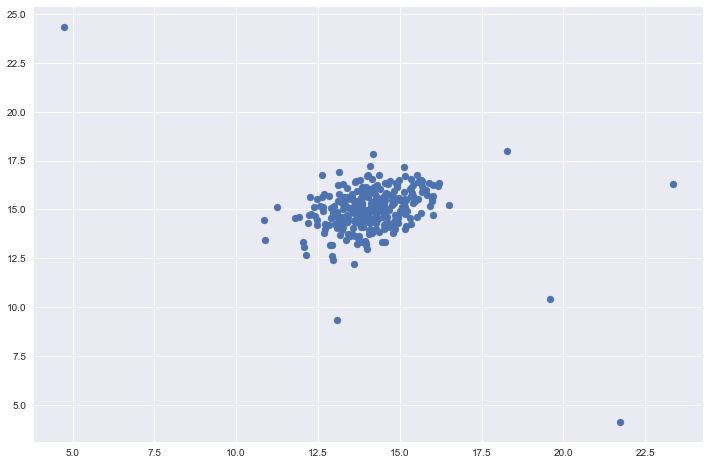

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])

It appears that there's a pretty tight cluster in the center with several values further out away from the cluser.  In this simple example, these could be considered anomalies.  To find out, we're tasking with estimating a gaussian distribution for each feature in the data.  To do this we'll create a function that returns the mean and variance for each feature.

In [18]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [19]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

Now that we have our model parameters, we need to determine a probability threshold which indicates that an example should be considered an anomaly.  To do this, we need to use a set of labeled validation data (where the true anomalies have been marked as such) and test the model's performance at identifying those anaomalies given different threshold values.

In [20]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

We also need a way to calculate the probability that a data point belongs to a normal distribution.  Fortunately SciPy has this built-in.

In [21]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

We can also pass in an array to the probability density function and get the probability density at every point in the data set.

In [22]:
dist.pdf(X[:,0])[0:50]

array([ 0.183842  ,  0.20221694,  0.21746136,  0.19778763,  0.20858956,
        0.21652359,  0.16991291,  0.15123542,  0.1163989 ,  0.1594734 ,
        0.21716057,  0.21760472,  0.20141857,  0.20157497,  0.21711385,
        0.21758775,  0.21695576,  0.2138258 ,  0.21057069,  0.1173018 ,
        0.20765108,  0.21717452,  0.19510663,  0.21702152,  0.17429399,
        0.15413455,  0.21000109,  0.20223586,  0.21031898,  0.21313426,
        0.16158946,  0.2170794 ,  0.17825767,  0.17414633,  0.1264951 ,
        0.19723662,  0.14538809,  0.21766361,  0.21191386,  0.21729442,
        0.21238912,  0.18799417,  0.21259798,  0.21752767,  0.20616968,
        0.21520366,  0.1280081 ,  0.21768113,  0.21539967,  0.16913173])

Let's compute and save the probability density of each of the values in our data set given the gaussian model parameters we calculated above.

In [23]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

We also need to do this for the validation set (using the same model parameters).  We'll use these probabilities combined with the true label to determine the optimal probability threshold to assign data points as anomalies.

In [24]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

Next, we need a function that finds the best threshold value given the probability density values and true labels.  To do this we'll calculate the F1 score for varying values of epsilon.  F1 is a function of the number of true positives, false positives, and false negatives.  The equations are in the exercise text.

In [25]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [29]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

/home/akhil/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.0095667060059568421, 0.7142857142857143)

Finally, we can apply the threshold to the data set and visualize the results.

In [30]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306]),
 array([1, 0, 1, 0, 1, 0, 0, 1]))

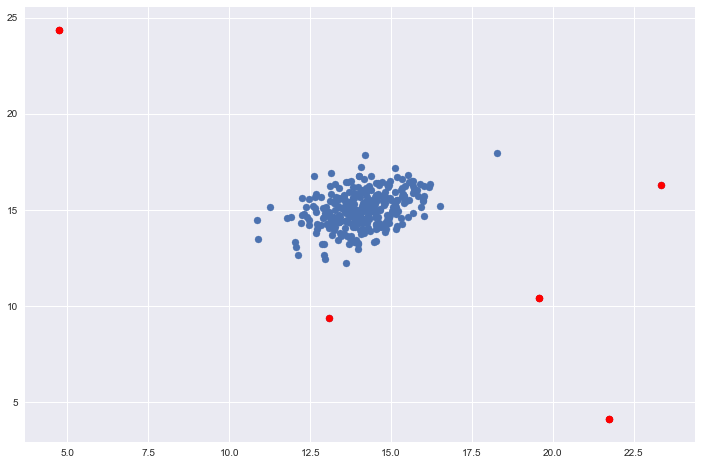

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')

The points in red are the ones that were flagged as outliers.  These seem pretty reasonable.  The top right point that has some separation (but was not flagged) may be an outlier too, but it's fairly close.  There's another example in the text of applying this to a higher-dimensional data set, but there's nothing new to do or look at so we'll move on to the last section.

## Collaborative filtering

Recommendation engines use item and user-based similarity measures to examine a user's historical preferences to make recommendations for new "things" the user might be interested in.  In this exercise we'll implement a particular recommendation system algorithm called collaborative filtering and apply it to a data set of movie ratings.

Let's first load and examine the data we'll be working with.

In [32]:
data = loadmat('/home/akhil/Desktop/dand/red/ipython-notebooks-master/data/ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

Y is a (number of movies x number of users) array containing ratings from 1 to 5.  R is an "indicator" array containing binary values indicating if a user has rated a movie or not.  Both should have the same shape.

In [16]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682L, 943L), (1682L, 943L))

We can look at the average rating for a movie by averaging over a row in Y for indexes where a rating is present.

In [17]:
Y[1,np.where(R[1,:]==1)[0]].mean()

2.5832449628844114

We can also try to "visualize" the data by rendering the matrix as if it were an image.  We can't glean too much from this but it does give us an idea of a relative density of ratings across users and movies.

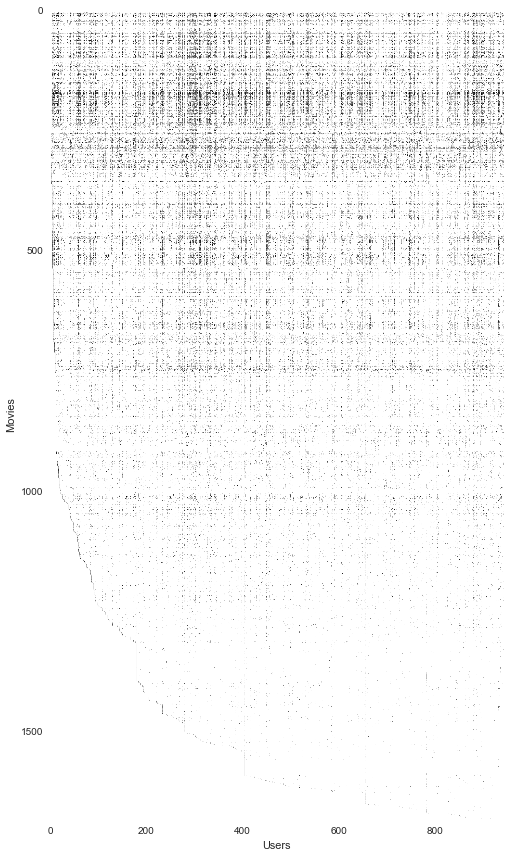

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()

Next we're going to implement a cost function for collaborative filtering.  Intuitively, the "cost" is the degree to which a set of movie rating predictions deviate from the true predictions.  The cost equation is given in the exercise text.  It is based on two sets of parameter matrices called X and Theta in the text.  These are "unrolled" into the "params" input so that we can use SciPy's optimization package later on.  Note that I've included the array/matrix shapes in comments (for the data we're using in this exercise) to help illustrate how the matrix interactions work.

In [19]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

In order to test this, we're provided with a set of pre-trained parameters that we can evaluate.  To keep the evaluation time down, we'll look at just a small sub-set of the data.

In [20]:
params_data = loadmat('data/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682L, 10L), (943L, 10L))

In [21]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

22.224603725685675

Great, this matches what the exercise text said we're supposed to get.  Next we need to implement the gradient computations.  Just like we did with the neural networks implementation in exercise 4, we'll extend the cost function to also compute the gradients.

In [22]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [23]:
J, grad = cost(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

Our next step is to add regularization to both the cost and gradient calculations.  We'll create one final regularized version of the function (note that this version includes an additional "learning rate" parameter, called "lambda" in the text).

In [24]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [25]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

This result again matches up with the expected output from the exercise code, so it looks like the regularization is working.  Before we train the model, we have one final step.  We're tasked with creating our own movie ratings so we can use the model to generate personalized recommendations.  A file is provided for us that links the movie index to its title.  Let's load the file into a dictionary.

In [14]:
movie_idx = {}
f = open('/home/akhil/Desktop/dand/red/ipython-notebooks-master/data/movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [27]:
movie_idx[0]

'Toy Story (1995)'

We'll use the ratings provided in the exercise.

In [28]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


We can add our own ratings vector to the existing data set to include in the model.

In [29]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

((1682L, 944L), (1682L, 944L), (1682L, 1L))

We're not just about ready to train the collaborative filtering model.  We just need to define some variables and normalize the ratings.

In [30]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682L, 10L), (944L, 10L), (26260L,))

In [31]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

Ynorm.mean()

5.5070364565159845e-19

In [32]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

  status: 1
 success: False
    njev: 149
    nfev: 149
     fun: 38953.88249706676
       x: array([-0.07177334, -0.08315075,  0.1081135 , ...,  0.1817828 ,
        0.16873062,  0.03383596])
 message: 'Maximum number of iterations has been exceeded.'
     jac: array([ 0.01833555,  0.07377974,  0.03999323, ..., -0.00970181,
        0.00758961, -0.01181811])

In [33]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682L, 10L), (944L, 10L))

Our trained parameters are now in X and Theta.  We can use these to create some recommendations for the user we added.

In [34]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
my_preds.shape

(1682L, 1L)

In [35]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[ 5.00000264],
        [ 5.00000249],
        [ 4.99999831],
        [ 4.99999671],
        [ 4.99999659],
        [ 4.99999253],
        [ 4.99999238],
        [ 4.9999915 ],
        [ 4.99999019],
        [ 4.99998643]])

That gives us an ordered list of the top ratings, but we lost what index those ratings are for.  We actually need to use argsort so we know what movie the predicted rating corresponds to.

In [36]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

matrix([[1188],
        [1499],
        [1200],
        ..., 
        [1660],
        [1493],
        [ 829]], dtype=int64)

In [37]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.00000264002 for movie Prefontaine (1997).
Predicted rating of 5.00000249142 for movie Santa with Muscles (1996).
Predicted rating of 4.99999831018 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 4.9999967124 for movie Saint of Fort Washington, The (1993).
Predicted rating of 4.99999658864 for movie They Made Me a Criminal (1939).
Predicted rating of 4.999992533 for movie Someone Else's America (1995).
Predicted rating of 4.99999238336 for movie Great Day in Harlem, A (1994).
Predicted rating of 4.99999149604 for movie Star Kid (1997).
Predicted rating of 4.99999018592 for movie Aiqing wansui (1994).
Predicted rating of 4.99998642746 for movie Entertaining Angels: The Dorothy Day Story (1996).


The recommended movies don't actually line up that well with what's in the exercise text.  The reason why isn't too clear and I haven't found anything to account for it.  If you spot a mistake somewhere, please let me know.  Even if there's some minor difference or a step in the original exercise that I missed, the bulk of the example is accurate.

That concludes the exercise and this notebook series!  I hope you learned as much as I did.  Thanks for reading.